In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for reproducibility
seed = 17#13#21#23
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Probability Distribution Generation

## Log-normal Distribution

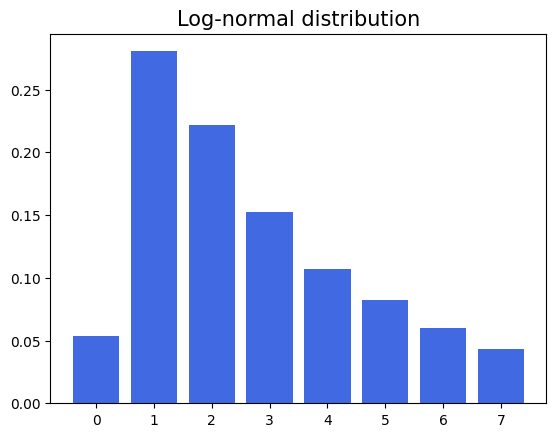

In [3]:
# Generate 20000 samples of following log-normal distribution truncated between 0-7

log_normal = np.random.lognormal(mean=1, sigma=1, size=30000)
integer_log_normal = np.round(log_normal)
truncated_log_normal = log_normal[log_normal < 7.5]
log_normal = np.round(truncated_log_normal[:20000])

# Show log-normal distribution
plt.hist(log_normal, bins=8, align='left', range=[0, 8], rwidth=0.8, density=True, color='royalblue')
plt.title('Log-normal distribution', fontsize=15)
plt.show()



In [4]:
def calculate_probabilities(samples, batch_size):
        # Initialize an array to hold counts of each possible result (0 to 15)
        probs = []
        
        for i in range(int(len(samples)/batch_size)):
            counts = np.zeros(8)
            data = samples[i*batch_size:(i+1)*batch_size]
            # Count the occurrences of each result
            for value in data:
                counts[int(value)] += 1
            
            # Calculate probabilities by normalizing the counts
            probabilities = counts / len(data)
            probs.append(probabilities)
        
        return np.array(probs)

log_probs = calculate_probabilities(log_normal, 2000)

In [5]:
class DistributionDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
# Create the data loader instance
log_dataset = DistributionDataset(log_probs)
log_dataloader = DataLoader(log_dataset, batch_size=1)

## Triangular Distribution

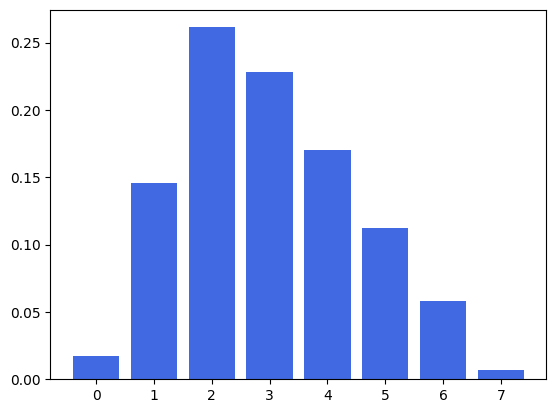

In [7]:
triangular = np.random.triangular(left=0, mode=2, right=7, size=30000)
integer_triangular = np.round(triangular)
#truncated_triangular = triangular[triangular < 7.5]
triangular = np.round(integer_triangular[:20000])

# Show log-normal distribution
plt.hist(triangular, bins=8, align='left', range=[0, 8], rwidth=0.8, density=True, color='royalblue')
plt.show()

In [8]:
def calculate_probabilities(samples, batch_size):
        # Initialize an array to hold counts of each possible result (0 to 15)
        probs = []
        
        for i in range(int(len(samples)/batch_size)):
            counts = np.zeros(8)
            data = samples[i*batch_size:(i+1)*batch_size]
            # Count the occurrences of each result
            for value in data:
                counts[int(value)] += 1
            
            # Calculate probabilities by normalizing the counts
            probabilities = counts / len(data)
            probs.append(probabilities)
        
        return np.array(probs)

triang_probs = calculate_probabilities(triangular, 2000)

In [9]:
class DistributionDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
# Create the data loader instance
triang_dataset = DistributionDataset(triang_probs)
triang_dataloader = DataLoader(triang_dataset, batch_size=1)

## Bimodal Distribution

In [11]:
# Generate 20000 samples with log-normal distribution
gaussian_1 = np.random.normal(loc=0.5, scale=1, size = 20000)
gaussian_2 = np.random.normal(loc=3.5, scale=0.5, size = 20000)
bimodal = np.concatenate((gaussian_1, gaussian_2))
np.random.shuffle(bimodal)
temp_bimodal = bimodal[bimodal < 7.5]
truncated_bimodal = temp_bimodal[temp_bimodal > 0]
bimodal = np.round(truncated_bimodal[:20000])

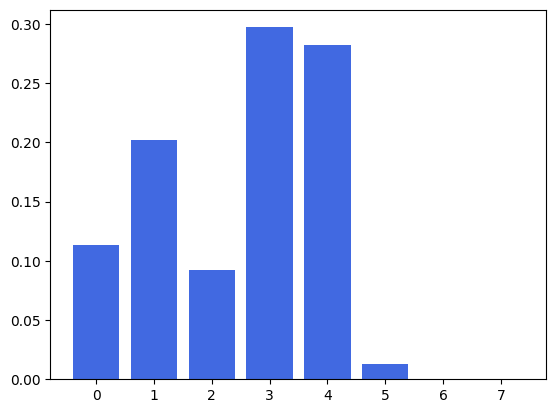

In [12]:
# Show log-normal distribution
plt.hist(bimodal, bins=8, align='left', range=[0, 8], rwidth=0.8, density=True, color='royalblue')
plt.show()

In [13]:
def calculate_probabilities(samples, batch_size):
        # Initialize an array to hold counts of each possible result (0 to 15)
        probs = []
        
        for i in range(int(len(samples)/batch_size)):
            counts = np.zeros(8)
            data = samples[i*batch_size:(i+1)*batch_size]
            # Count the occurrences of each result
            for value in data:
                counts[int(value)] += 1
            
            # Calculate probabilities by normalizing the counts
            probabilities = counts / len(data)
            probs.append(probabilities)
        
        return np.array(probs)

bimodal_probs = calculate_probabilities(bimodal, 2000)

In [14]:
class DistributionDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
# Create the data loader instance
bimodal_dataset = DistributionDataset(bimodal_probs)
bimodal_dataloader = DataLoader(bimodal_dataset, batch_size=1)

# Quantum Generative Adversarial Network

In [16]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(8, 50),
            nn.LeakyReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(50, 20),
            nn.LeakyReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)

In [17]:
n_qubits = 3
n_a_qubits = 0
q_depth = 3 

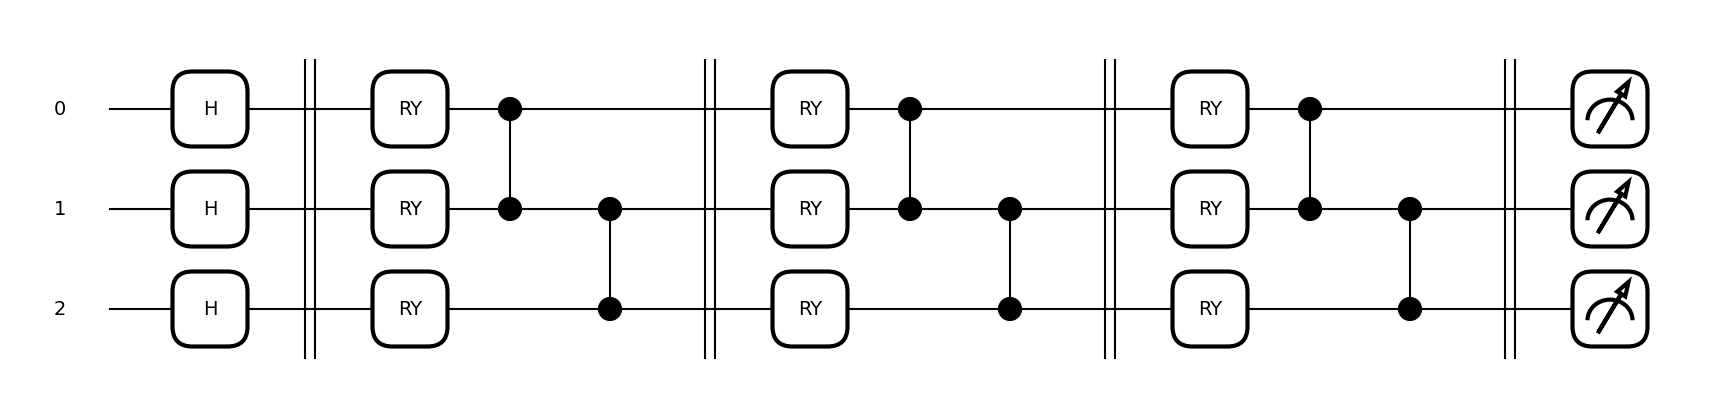

In [18]:
dev = qml.device("lightning.qubit", wires=n_qubits, shots=2000)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [19]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = quantum_circuit(self.q_params[0]).float().unsqueeze(0)
        
        return qc_out

# Training

## Log-normal Distribution

In [20]:
log_discriminator = Discriminator().to(device)
log_generator = QuantumGenerator().to(device)

In [21]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [22]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(log_discriminator.parameters(), lr=lrD)
optG = optim.SGD(log_generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [23]:
while True:
    for i, data in enumerate(log_dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = log_generator()

        # Training the discriminator
        log_discriminator.zero_grad()
        outD_real = log_discriminator(real_data).view(-1)
        outD_fake = log_discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        log_generator.zero_grad()
        outD_fake = log_discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break


Iteration: 0, Discriminator Loss: 1.383, Generator Loss: 0.709
Iteration: 10, Discriminator Loss: 1.362, Generator Loss: 0.729
Iteration: 20, Discriminator Loss: 1.392, Generator Loss: 0.691
Iteration: 30, Discriminator Loss: 1.394, Generator Loss: 0.684
Iteration: 40, Discriminator Loss: 1.394, Generator Loss: 0.687
Iteration: 50, Discriminator Loss: 1.391, Generator Loss: 0.692
Iteration: 60, Discriminator Loss: 1.389, Generator Loss: 0.694
Iteration: 70, Discriminator Loss: 1.387, Generator Loss: 0.695
Iteration: 80, Discriminator Loss: 1.385, Generator Loss: 0.696
Iteration: 90, Discriminator Loss: 1.383, Generator Loss: 0.696
Iteration: 100, Discriminator Loss: 1.381, Generator Loss: 0.696
Iteration: 110, Discriminator Loss: 1.380, Generator Loss: 0.697
Iteration: 120, Discriminator Loss: 1.377, Generator Loss: 0.699
Iteration: 130, Discriminator Loss: 1.376, Generator Loss: 0.701
Iteration: 140, Discriminator Loss: 1.382, Generator Loss: 0.695
Iteration: 150, Discriminator Loss: 

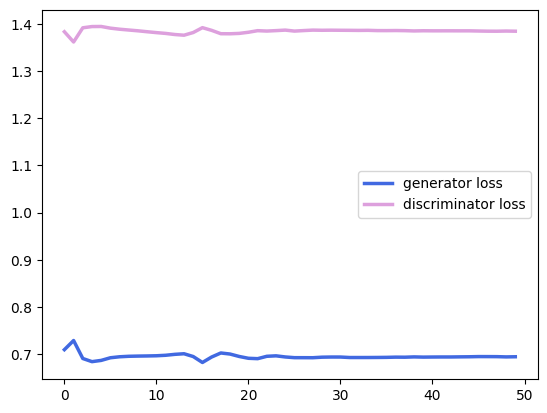

In [24]:
plt.plot(gen_loss, label="generator loss", color='royalblue', linewidth=2.5)
plt.plot(disc_loss, label="discriminator loss", color="plum", linewidth=2.5)
plt.legend()
plt.show()

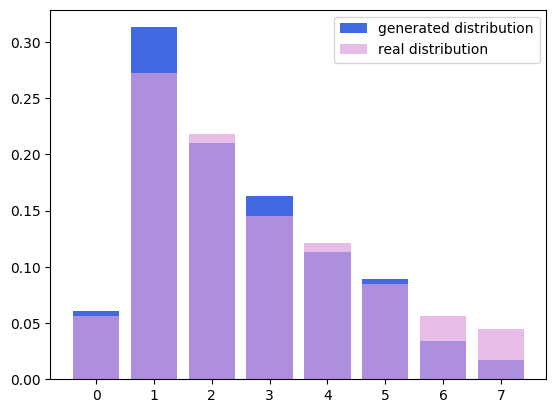

In [90]:
t = log_generator().detach().numpy()
x = list(range(8))
plt.bar(x, t[0], color="royalblue", label="generated distribution")
plt.bar(x, log_probs[1], color="plum", alpha=0.7, label="real distribution")
plt.legend()
plt.show()

## Triangular Distribution

In [26]:
triang_discriminator = Discriminator().to(device)
triang_generator = QuantumGenerator().to(device)

In [27]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [28]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(triang_discriminator.parameters(), lr=lrD)
optG = optim.SGD(triang_generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [29]:
while True:
    for i, data in enumerate(triang_dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = triang_generator()

        # Training the discriminator
        triang_discriminator.zero_grad()
        outD_real = triang_discriminator(real_data).view(-1)
        outD_fake = triang_discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        triang_generator.zero_grad()
        outD_fake = triang_discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break

Iteration: 0, Discriminator Loss: 1.391, Generator Loss: 0.804
Iteration: 10, Discriminator Loss: 1.384, Generator Loss: 0.739
Iteration: 20, Discriminator Loss: 1.384, Generator Loss: 0.715
Iteration: 30, Discriminator Loss: 1.383, Generator Loss: 0.705
Iteration: 40, Discriminator Loss: 1.384, Generator Loss: 0.699
Iteration: 50, Discriminator Loss: 1.385, Generator Loss: 0.696
Iteration: 60, Discriminator Loss: 1.386, Generator Loss: 0.693
Iteration: 70, Discriminator Loss: 1.386, Generator Loss: 0.693
Iteration: 80, Discriminator Loss: 1.387, Generator Loss: 0.693
Iteration: 90, Discriminator Loss: 1.386, Generator Loss: 0.694
Iteration: 100, Discriminator Loss: 1.386, Generator Loss: 0.693
Iteration: 110, Discriminator Loss: 1.386, Generator Loss: 0.694
Iteration: 120, Discriminator Loss: 1.386, Generator Loss: 0.694
Iteration: 130, Discriminator Loss: 1.387, Generator Loss: 0.694
Iteration: 140, Discriminator Loss: 1.387, Generator Loss: 0.693
Iteration: 150, Discriminator Loss: 

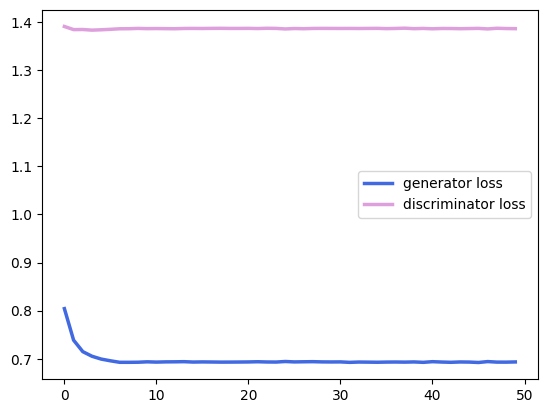

In [30]:
plt.plot(gen_loss, label="generator loss", color='royalblue', linewidth=2.5)
plt.plot(disc_loss, label="discriminator loss", color="plum", linewidth=2.5)
plt.legend()
plt.show()

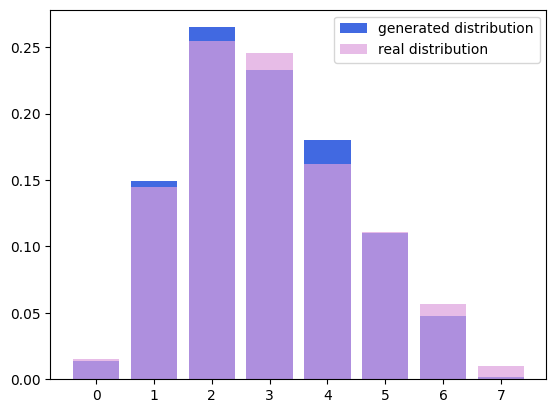

In [67]:
t = triang_generator().detach().numpy()
x = list(range(8))
plt.bar(x, t[0], color="royalblue", label="generated distribution")
plt.bar(x, triang_probs[2], color="plum", alpha=0.7, label="real distribution")
plt.legend()
plt.show()

## Bimodal Distribution

In [32]:
bimodal_discriminator = Discriminator().to(device)
bimodal_generator = QuantumGenerator().to(device)

In [33]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.005  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [34]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(bimodal_discriminator.parameters(), lr=lrD)
optG = optim.SGD(bimodal_generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [35]:
while True:
    for i, data in enumerate(bimodal_dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = bimodal_generator()

        # Training the discriminator
        bimodal_discriminator.zero_grad()
        outD_real = bimodal_discriminator(real_data).view(-1)
        outD_fake = bimodal_discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        bimodal_generator.zero_grad()
        outD_fake = bimodal_discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break

Iteration: 0, Discriminator Loss: 1.381, Generator Loss: 0.736
Iteration: 10, Discriminator Loss: 1.363, Generator Loss: 0.737
Iteration: 20, Discriminator Loss: 1.371, Generator Loss: 0.715
Iteration: 30, Discriminator Loss: 1.375, Generator Loss: 0.702
Iteration: 40, Discriminator Loss: 1.383, Generator Loss: 0.693
Iteration: 50, Discriminator Loss: 1.382, Generator Loss: 0.693
Iteration: 60, Discriminator Loss: 1.379, Generator Loss: 0.694
Iteration: 70, Discriminator Loss: 1.379, Generator Loss: 0.693
Iteration: 80, Discriminator Loss: 1.381, Generator Loss: 0.691
Iteration: 90, Discriminator Loss: 1.381, Generator Loss: 0.691
Iteration: 100, Discriminator Loss: 1.382, Generator Loss: 0.690
Iteration: 110, Discriminator Loss: 1.383, Generator Loss: 0.692
Iteration: 120, Discriminator Loss: 1.381, Generator Loss: 0.694
Iteration: 130, Discriminator Loss: 1.379, Generator Loss: 0.697
Iteration: 140, Discriminator Loss: 1.379, Generator Loss: 0.696
Iteration: 150, Discriminator Loss: 

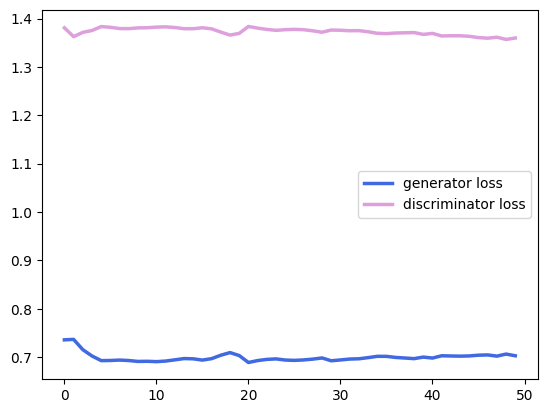

In [36]:
plt.plot(gen_loss, label="generator loss", color='royalblue', linewidth=2.5)
plt.plot(disc_loss, label="discriminator loss", color="plum", linewidth=2.5)
plt.legend()
plt.show()

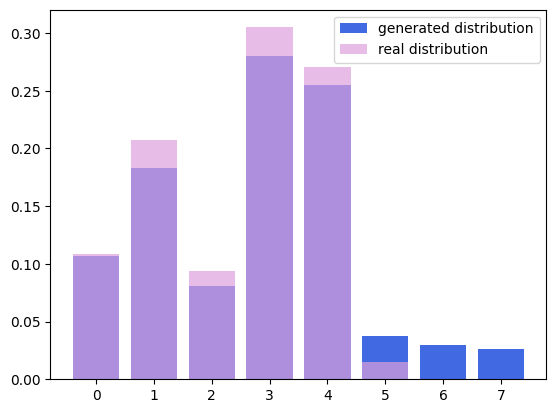

In [49]:
t = bimodal_generator().detach().numpy()
x = list(range(8))
plt.bar(x, t[0], color="royalblue", label="generated distribution")
plt.bar(x, bimodal_probs[0], color="plum", alpha=0.7, label="real distribution")
plt.legend()
plt.show()